In [7]:
import pandas as pd
import os
import glob

# Define o path pattern para todos os CSVs
path_pattern = '../../Data/Data_Exploration/descriptive_stats_*.csv'

# Encontrar todos os CSVs
csv_files = glob.glob(path_pattern)

# Garantir que o CSV model_sqrt esteja incluído
sqrt_file = '../../Data/Data_Exploration/descriptive_stats_PT-FireProg_v2.1_L2_model_sqrt.csv'
if sqrt_file not in csv_files:
    csv_files.append(sqrt_file)

# Dicionário para armazenar as correlações por variável
correlations_data = {}

# Processar cada CSV
for file_path in csv_files:
    try:
        df = pd.read_csv(file_path)

        if 'corr_ros_p' in df.columns:  # Usar corr_ros_p em vez de corr_ros_p
            filename = os.path.basename(file_path).lower()
            
            # Determinar tipo de transformação
            if 'model' in filename and 'log' in filename:
                col_suffix = 'model_log'
            elif 'model' in filename and 'sqrt' in filename:
                col_suffix = 'model_sqrt'
            elif 'model' in filename:
                col_suffix = 'model'
            else:
                print(f"Warning: Could not determine type for {filename}")
                continue

            # Extrair nomes das variáveis e valores de corr_ros_p
            for idx, row in df.iterrows():
                if pd.notna(row['corr_ros_p']):
                    variable_name = df.iloc[idx, 0]  # Primeira coluna tem os nomes das variáveis
                    
                    if variable_name not in correlations_data:
                        correlations_data[variable_name] = {'variable': variable_name}
                    
                    correlations_data[variable_name][f'corr_ros_p_{col_suffix}'] = row['corr_ros_p']

        else:
            print(f"Warning: corr_ros_p column not found in {file_path}")

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")

# Criar DataFrame consolidado
if correlations_data:
    correlations_df = pd.DataFrame(correlations_data.values())

    # Colunas desejadas
    desired_columns = [
        'variable',
        'corr_ros_p_model',
        'corr_ros_p_model_log',
        'corr_ros_p_model_sqrt'
    ]

    # Adicionar colunas ausentes com NaN
    for col in desired_columns:
        if col not in correlations_df.columns:
            correlations_df[col] = None

    correlations_df = correlations_df[desired_columns]

    # Salvar CSV final
    output_file = '../../Data/Data_Exploration/all_ros_p_correlations.csv'
    correlations_df.to_csv(output_file, index=False)

    print(f"Successfully created {output_file}")
    print(f"Total variables: {len(correlations_df)}")
    print(f"Files processed: {len(csv_files)}")
    print(f"\nDataFrame structure:")
    print(correlations_df.head())

else:
    print("No correlation data found in any of the files")


Successfully created ../../Data/Data_Exploration/all_ros_p_correlations.csv
Total variables: 106
Files processed: 4

DataFrame structure:
     variable  corr_ros_p_model  corr_ros_p_model_log  corr_ros_p_model_sqrt
0  1_3y_fir_p         -0.084606             -0.096090              -0.098683
1  3_8y_fir_p         -0.040647              0.004731              -0.007800
2  8_ny_fir_p          0.003310              0.060786               0.045843
3    BLH_m_av          0.133288              0.248565               0.186454
4    BLH_m_rt          0.055893              0.010307               0.042689


In [ ]:
# Parâmetros
top_n = 15
missing_threshold = 0.30  # 30%

# Lista para armazenar variáveis com missing >30% por CSV
vars_missing_por_csv = {}

# Agrupar por CSV (ajuste o nome da coluna se necessário)
for csv_name, df_csv in correlations_df.groupby("csv_name"):

    # Identificar variáveis com % missing acima do limiar
    vars_missing = df_csv.loc[df_csv["pct_missing"] > missing_threshold, "variable"].tolist()
    vars_missing_por_csv[csv_name] = vars_missing

    print(f"\nVariáveis com >30% missing no arquivo {csv_name}:")
    print(vars_missing if vars_missing else "Nenhuma variável acima do limiar.")

    # Filtrar o DF removendo variáveis acima do limite de missing
    df_filtrado = df_csv[df_csv["pct_missing"] <= missing_threshold]

    # Gerar top correlations para cada transformação
    for col in ['corr_ros_p_model', 'corr_ros_p_model_sqrt', 'corr_ros_p_model_log']:
        if col in df_filtrado.columns:

            # Ordenar por valor absoluto
            top_vars = df_filtrado.reindex(
                df_filtrado[col].abs().sort_values(ascending=False).index
            ).head(top_n)

            print(f"\nTop {top_n} |correlation| para {col} no arquivo {csv_name}:")
            print(top_vars[['variable', col]])



Top 15 |correlation| for corr_ros_p_model:
       variable  corr_ros_p_model
9        Cin_av          1.000000
56    ros_p_lg6          0.697145
57    ros_p_lg7          0.637884
58    ros_p_lg8          0.612918
50    ros_p_lg1          0.457074
101   wv_950_av          0.435956
93     wv100_av          0.425657
94   wv100_k_av          0.423669
53    ros_p_lg3          0.420549
105    landform          0.417483
23   VentIdx_av          0.400173
95      wv10_av          0.391852
96   wv10_kh_av          0.389857
100   wv_850_av          0.366683
65     sW_3m_av         -0.362599

Top 15 |correlation| for corr_ros_p_model_sqrt:
       variable  corr_ros_p_model_sqrt
9        Cin_av               1.000000
57    ros_p_lg7               0.719130
56    ros_p_lg6               0.689008
58    ros_p_lg8               0.658455
55    ros_p_lg5               0.492445
54    ros_p_lg4               0.452669
93     wv100_av               0.424535
94   wv100_k_av               0.417073
96   wv10_kh

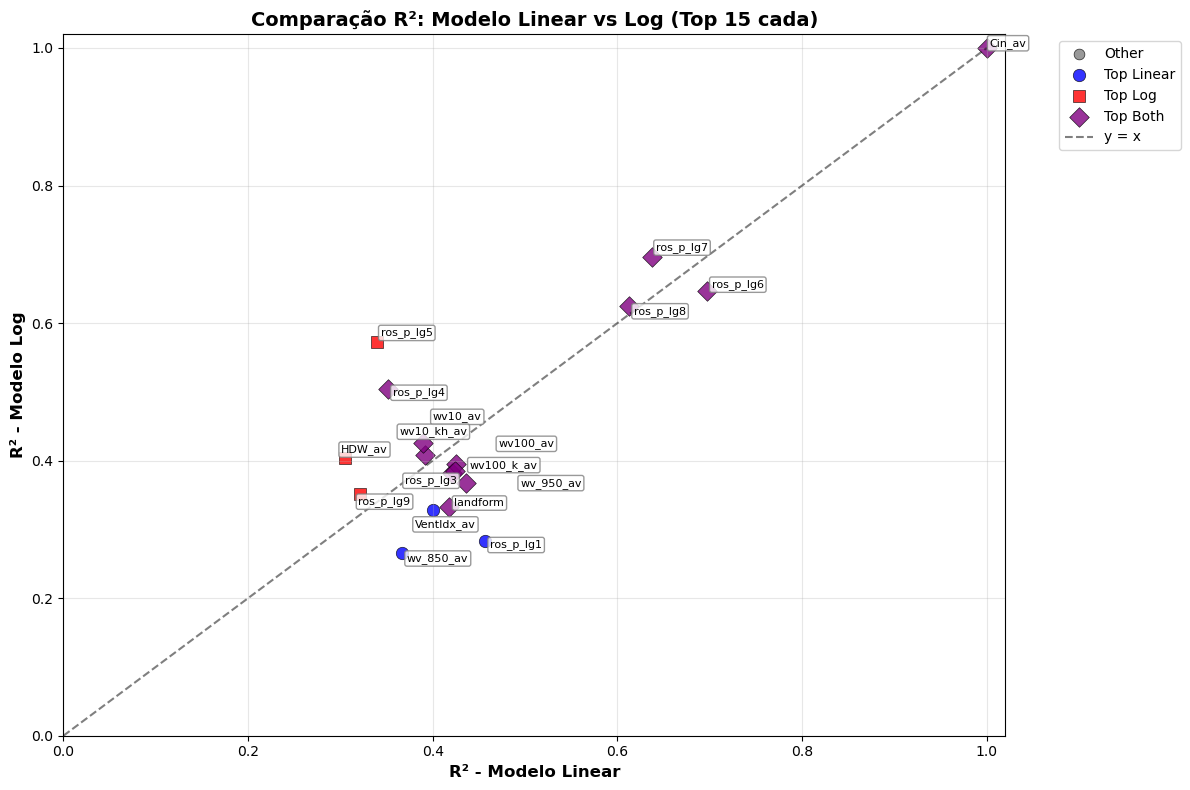

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

# Lendo o arquivo CSV
df = pd.read_csv('..\\..\\Data\\Data_Exploration\\all_ros_p_correlations.csv')

# Ordenando pelos maiores R² para cada modelo
top15_linear = df.nlargest(15, 'corr_ros_p_model')[['variable', 'corr_ros_p_model']]
top15_log = df.nlargest(15, 'corr_ros_p_model_log')[['variable', 'corr_ros_p_model_log']]

# Juntando todos os candidatos únicos
all_top_vars = set(top15_linear['variable']).union(set(top15_log['variable']))
comparison_data = df[df['variable'].isin(all_top_vars)]

# Classificando os pontos
comparison_data = comparison_data.copy()
comparison_data['category'] = 'Other'
comparison_data.loc[comparison_data['variable'].isin(top15_linear['variable']), 'category'] = 'Top Linear'
comparison_data.loc[comparison_data['variable'].isin(top15_log['variable']), 'category'] = 'Top Log'
comparison_data.loc[comparison_data['variable'].isin(top15_linear['variable']) & 
                   comparison_data['variable'].isin(top15_log['variable']), 'category'] = 'Top Both'

# Criando scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

# Definindo cores e marcadores para cada categoria
colors = {'Top Linear': 'blue', 'Top Log': 'red', 'Top Both': 'purple', 'Other': 'gray'}
markers = {'Top Linear': 'o', 'Top Log': 's', 'Top Both': 'D', 'Other': 'o'}
sizes = {'Top Linear': 80, 'Top Log': 80, 'Top Both': 100, 'Other': 60}

# Plotando cada categoria separadamente
for category in ['Other', 'Top Linear', 'Top Log', 'Top Both']:
    cat_data = comparison_data[comparison_data['category'] == category]
    ax.scatter(cat_data['corr_ros_p_model'], 
               cat_data['corr_ros_p_model_log'], 
               alpha=0.8, s=sizes[category],
               c=colors[category], marker=markers[category],
               label=category, edgecolors='black', linewidth=0.5)

# Linha de igualdade
max_val = max(comparison_data[['corr_ros_p_model', 'corr_ros_p_model_log']].max().max(), 0.15)
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='y = x')

ax.set_xlabel('R² - Modelo Linear', fontsize=12, fontweight='bold')
ax.set_ylabel('R² - Modelo Log', fontsize=12, fontweight='bold')
ax.set_title('Comparação R²: Modelo Linear vs Log (Top 15 cada)', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)

# SOLUÇÃO: Usar adjust_text sem arrowprops ou com configurações específicas
texts = []
for i, row in comparison_data.iterrows():
    if row['category'] in ['Top Linear', 'Top Log', 'Top Both']:
        text = ax.annotate(row['variable'], 
                          (row['corr_ros_p_model'], row['corr_ros_p_model_log']),
                          fontsize=8,
                          bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8, edgecolor='gray'))
        texts.append(text)

# Opção 1: Sem arrowprops (mais simples)
adjust_text(texts,
            expand_points=(1.5, 1.5),
            expand_text=(1.2, 1.2), 
            force_points=0.5,
            force_text=0.5,
            lim=1000)

plt.xlim(0, max_val + 0.02)
plt.ylim(0, max_val + 0.02)
plt.tight_layout()
plt.show()